In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from sqlalchemy import create_engine
from ds100_utils import fetch_and_cache

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
#pd.set_option('precision', 2)

## SQL Joins

In [18]:
import sqlite3
conn = sqlite3.connect('test13.db')

In [19]:
conn.executescript("""
DROP TABLE IF EXISTS s;
DROP TABLE IF EXISTS t;

CREATE TABLE s(
    id INTEGER PRIMARY KEY, 
    name TEXT
);

INSERT INTO s VALUES 
    (-1, 'Apricot'),
    (1, 'Boots'),
    (2, 'Cally'),
    (4, 'Eugene');

CREATE TABLE t(
    id INTEGER PRIMARY KEY,
    breed TEXT
);

INSERT INTO t VALUES 
    (1, 'persian'),
    (2, 'ragdoll'),
    (4, 'bengal'),
    (5, 'persian');
""");

In [20]:
def print_sql(s):
    for result in conn.execute(s):
        print(result)

print_sql('SELECT * FROM s;')


(-1, 'Apricot')
(1, 'Boots')
(2, 'Cally')
(4, 'Eugene')


In [21]:
print_sql('SELECT * FROM t;')

(1, 'persian')
(2, 'ragdoll')
(4, 'bengal')
(5, 'persian')


In [22]:
query = '''
SELECT *
FROM s
WHERE id >= 2;
'''

print_sql(query)

(2, 'Cally')
(4, 'Eugene')


In [23]:
#cross join
query = '''
SELECT *
FROM s, t
'''
print_sql(query)

(-1, 'Apricot', 1, 'persian')
(-1, 'Apricot', 2, 'ragdoll')
(-1, 'Apricot', 4, 'bengal')
(-1, 'Apricot', 5, 'persian')
(1, 'Boots', 1, 'persian')
(1, 'Boots', 2, 'ragdoll')
(1, 'Boots', 4, 'bengal')
(1, 'Boots', 5, 'persian')
(2, 'Cally', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(2, 'Cally', 4, 'bengal')
(2, 'Cally', 5, 'persian')
(4, 'Eugene', 1, 'persian')
(4, 'Eugene', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')
(4, 'Eugene', 5, 'persian')


In [24]:
#inner join
query = '''
SELECT *
FROM s JOIN t
  ON s.id = t.id
'''
print_sql(query)

(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [25]:
#left outer join
query = '''
SELECT *
FROM s LEFT JOIN t
  ON s.id = t.id
  where s.id > 1
'''
print_sql(query)

(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [26]:
#right inner join unsupported, so we have to switch s and t
query = '''
SELECT *
FROM t LEFT JOIN s
  ON s.id = t.id
'''
print_sql(query)

(1, 'persian', 1, 'Boots')
(2, 'ragdoll', 2, 'Cally')
(4, 'bengal', 4, 'Eugene')
(5, 'persian', None, None)


Doing an outer join is possible but is not very concise and requires UNION keyword.

In [27]:
#full outer join with UNION
query = '''
SELECT s.id, s.name, t.id, t.breed
FROM s LEFT JOIN t
  ON s.id = t.id
UNION
SELECT s.id, s.name, t.id, t.breed
FROM t LEFT JOIN s
  ON s.id = t.id
'''
print_sql(query)

(None, None, 5, 'persian')
(-1, 'Apricot', None, None)
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [28]:
conn.executescript("""
DROP TABLE IF EXISTS student;
DROP TABLE IF EXISTS teacher;

CREATE TABLE student(
    age INTEGER, 
    name TEXT
);

INSERT INTO student VALUES 
    (29, 'James'),
    (37, 'Jin'),
    (20, 'John'),
    (20, 'Emma');

CREATE TABLE teacher(
    age INTEGER,
    name TEXT
);

INSERT INTO teacher VALUES 
    (52, 'Ian'),
    (41, 'Hellen'),
    (27, 'John'),
    (36, 'Anne');
""");

In [29]:
#
query = '''
SELECT * FROM student, teacher WHERE student.age > teacher.age
'''
print_sql(query)

(29, 'James', 27, 'John')
(37, 'Jin', 27, 'John')
(37, 'Jin', 36, 'Anne')


In [30]:
conn.executescript("""


INSERT INTO student VALUES 
    (2, NULL);

""");

In [31]:
#
query = '''
SELECT * FROM student WHERE name is NULL
'''
print_sql(query)

(2, None)


In [32]:
#
query = '''
SELECT * FROM student
'''
print_sql(query)

(29, 'James')
(37, 'Jin')
(20, 'John')
(20, 'Emma')
(2, None)


In [33]:
# count ignore null values
query = '''
SELECT COUNT(t.id) FROM s LEFT JOIN t ON s.id = t.id
'''
print_sql(query)

(3,)


In [34]:
# count ignore null values
query = '''
SELECT SUM(t.id) FROM s LEFT JOIN t ON s.id = t.id
'''
print_sql(query)

(7,)


In [35]:
#
query = '''
SELECT * FROM s LEFT JOIN t ON s.id = t.id 
'''
print_sql(query)
# how to handle this correctly?  https://learnsql.com/blog/null-comparison-operators/

(-1, 'Apricot', None, None)
(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


In [36]:
#
query = '''
SELECT * FROM s LEFT JOIN t ON s.id = t.id where t.breed is NOT NULL
'''
print_sql(query)
# how to handle this correctly?  https://learnsql.com/blog/null-comparison-operators/

(1, 'Boots', 1, 'persian')
(2, 'Cally', 2, 'ragdoll')
(4, 'Eugene', 4, 'bengal')


## IMDB Data

In [37]:
data_directory = './'

In [38]:
# From https://www.imdb.com/interfaces/
fetch_and_cache('https://datasets.imdbws.com/title.basics.tsv.gz', 'titles.tsv.gz', data_directory)
fetch_and_cache('https://datasets.imdbws.com/name.basics.tsv.gz', 'names.tsv.gz', data_directory)
!gunzip -kf {data_directory}/titles.tsv.gz
!gunzip -kf {data_directory}/names.tsv.gz
!ls -lh {data_directory}

Using cached version that was downloaded (UTC): Tue Oct 15 23:24:17 2024
Using cached version that was downloaded (UTC): Tue Oct 15 23:24:24 2024
total 4500208
-rw-r--r--@ 1 seankang  staff    65K Oct 15 23:25 Lecture 13 - SQL.ipynb
-rw-r--r--@ 1 seankang  staff   595K Oct  9 22:18 Lecture 13 - SQL.pdf
-rw-r--r--@ 1 seankang  staff   1.7M Feb 27  2024 Lecture 13 - SQL.pptx
-rw-r--r--@ 1 seankang  staff   1.0M Oct  9 22:19 Lecture 14. Modeling.pdf
-rw-r--r--@ 1 seankang  staff   2.1M Mar  2  2024 Lecture 14. Modeling.pptx
-rw-r--r--@ 1 seankang  staff    39K Oct 15 23:18 SQLtests.ipynb
drwxr-xr-x@ 3 seankang  staff    96B Oct 15 21:33 __pycache__
-rw-r--r--@ 1 seankang  staff   1.6K Dec  8  2023 ds100_utils.py
-rw-r--r--@ 1 seankang  staff   814M Oct 15 23:24 names.tsv
-rw-r--r--@ 1 seankang  staff   261M Oct 15 23:24 names.tsv.gz
-rw-r--r--@ 1 seankang  staff    20K Oct 15 23:25 test13.db
-rw-r--r--@ 1 seankang  staff   916M Oct 15 23:24 titles.tsv
-rw-r--r--@ 1 seankang  staff   187M 

In [39]:
# Running the line below will probaly crash your kernel because the names 
# dataset is too big to comfortable fit into main memory. 
#pd.read_csv(f'{data_directory}/names.tsv', sep='\t')

In [40]:
# Use sqlite3 instead of Python (must be run from the terminal)
# note: To close sqlite3, press ctrl-d
"""
$ sqlite3 imdb.db
sqlite> .mode tabs
sqlite> .import titles.tsv titles
sqlite> .import names.tsv names
""";

While the code above runs, let's explore the data files a bit.

In [41]:
!wc {data_directory}/*.tsv

 13873519 98257811 853080680 .//names.tsv
 11159294 151600337 960914725 .//titles.tsv
 25032813 249858148 1813995405 total


In [42]:
!head -n5 {data_directory}/titles.tsv

tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	5	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	12	Animation,Short


In [43]:
!head -n5 {data_directory}/names.tsv

nconst	primaryName	birthYear	deathYear	primaryProfession	knownForTitles
nm0000001	Fred Astaire	1899	1987	actor,miscellaneous,producer	tt0072308,tt0050419,tt0053137,tt0027125
nm0000002	Lauren Bacall	1924	2014	actress,soundtrack,archive_footage	tt0037382,tt0075213,tt0117057,tt0038355
nm0000003	Brigitte Bardot	1934	\N	actress,music_department,producer	tt0057345,tt0049189,tt0056404,tt0054452
nm0000004	John Belushi	1949	1982	actor,writer,music_department	tt0072562,tt0077975,tt0080455,tt0078723


In [44]:
conn = sqlite3.connect(data_directory + '/imdb.db')
sql_query = """SELECT name FROM sqlite_master WHERE type='table';"""
cursor = conn.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[]


In [46]:
conn = sqlite3.connect(data_directory + '/imdb.db')
#print_sql('SELECT * FROM titles LIMIT 10;')

In [47]:
for exp in conn.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

In [48]:
# Reminder: Python f strings
who, where = 'John', 'here'
f"{who} is {where}"

'John is here'

In [49]:
get_10_movies = f'''
SELECT primaryTitle AS title, 
  runtimeMinutes AS time
FROM titles
LIMIT 10;
'''

print_sql(get_10_movies)

OperationalError: no such table: titles

In [ ]:
get_10_movies_time_as_int = f'''
SELECT primaryTitle AS title, 
  CAST(runtimeMinutes as int) AS time
FROM titles
LIMIT 10;
'''

print_sql(get_10_movies_time_as_int)

('Carmencita', 1)
('Le clown et ses chiens', 5)
('Pauvre Pierrot', 4)
('Un bon bock', 12)
('Blacksmith Scene', 1)
('Chinese Opium Den', 1)
('Corbett and Courtney Before the Kinetograph', 1)
('Edison Kinetoscopic Record of a Sneeze', 1)
('Miss Jerry', 45)
('Leaving the Factory', 1)


In [ ]:
select_action = f'''
SELECT tconst AS id,
  primaryTitle AS title, 
  CAST(runtimeMinutes AS int) AS time, 
  CAST(startYear AS int) AS year
FROM titles
WHERE genres LIKE '%Action%' AND
  year > 1900 AND 
  isAdult = '0' AND
  titleType = 'movie' AND
  time > 60 AND time < 180
'''

create_action_table = f'''
DROP TABLE IF EXISTS action_movie;
CREATE TABLE action_movie AS {select_action};
'''

conn.executescript(create_action_table)
print_sql('SELECT * FROM action_movie LIMIT 10')

('tt0000574', 'The Story of the Kelly Gang', 70, 1906)
('tt0002574', 'What Happened to Mary', 150, 1912)
('tt0004223', 'The Life of General Villa', 105, 1914)
('tt0004450', 'Die Pagode', 82, 1917)
('tt0004635', 'The Squaw Man', 74, 1914)
('tt0005073', 'The Chalice of Courage', 65, 1915)
('tt0006333', '20,000 Leagues Under the Sea', 85, 1916)
('tt0006997', 'The Warrior', 95, 1916)
('tt0007168', 'Die Peitsche', 85, 1916)
('tt0008114', 'Die Hochzeit im Excentricclub', 70, 1917)


We can check to see whether this table is small enough to read into pandas:

In [ ]:
print_sql('SELECT COUNT(*) from action_movie')

(28478,)


In [ ]:
df = pd.read_sql('SELECT * FROM action_movie', conn)
df

,id,title,time,year
0,tt0000574,The Story of the Kelly Gang,70,1906
1,tt0002574,What Happened to Mary,150,1912
2,tt0004223,The Life of General Villa,105,1914
...,...,...,...,...
28475,tt9900908,Useless Handcuffs,89,1969
28476,tt9904066,Fox Hunting,66,2019
28477,tt9904802,Enemy Lines,92,2020


In [ ]:
df.shape

(28478, 4)

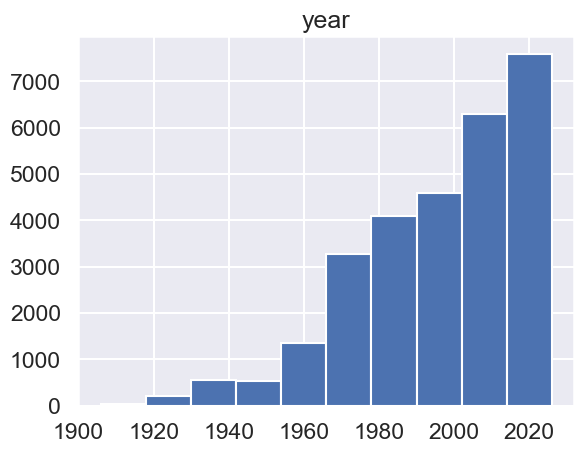

In [ ]:
df.hist('year');

In [ ]:
#sns.scatterplot(df['year'], df['time']);

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
sns.kdeplot(df['year'], df['time']);

In [ ]:
df['time'].groupby(df['year']).mean().plot();

In [ ]:
df['decade'] = (df['year'] // 10) * 10
sns.boxplot('decade', 'time', data=df)
plt.xticks(rotation=45);

## Sampling in SQL

In [ ]:
pd.read_sql('SELECT * FROM action_movie ORDER BY RANDOM() LIMIT 3', conn)

In [ ]:
#selecting 3 random years
three_years = '''
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

pd.read_sql(three_years, conn)

In [ ]:
#selecting all movies from 3 random years
three_years = '''
SELECT year FROM action_movie 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

cluster_sample = f'''
SELECT * FROM action_movie 
WHERE year IN ({three_years})
'''

pd.read_sql(f'''
SELECT *
FROM ({cluster_sample}) 
''', conn)

In [ ]:
# Query has two select statements
# Inner select statement creates the table of 3 randomly chosen years.
print(cluster_sample)

## Ages of Fame

#### CASE Example

In [ ]:
#case statement example
pd.read_sql('''
SELECT id, title, time, year,
     CASE WHEN time < 70 THEN 'short'
          WHEN time < 120 THEN 'medium'
          ELSE 'long'
     END as length
          
FROM action_movie
''', conn).sample(10)

In [ ]:
#case statement example with a base expression
pd.read_sql('''
SELECT id, title, time, year,
     CASE year LIKE '%197%' WHEN True THEN '70s'          
          ELSE 'not 70s'
     END as decade
          
FROM action_movie
''', conn).sample(10)

#### SUBSTR Example

In [ ]:
select_people = f'''
SELECT primaryName AS name, knownForTitles  
FROM names
'''

pd.read_sql(f'{select_people} LIMIT 10', conn)

In [ ]:
select_people = f'''
SELECT primaryName AS name,   
  SUBSTR(knownForTitles, 0, INSTR(knownForTitles, ',')) AS most_popular_id
FROM names
'''

pd.read_sql(f'{select_people} LIMIT 10', conn)

,name,most_popular_id
0,Fred Astaire,tt0027125
1,Lauren Bacall,tt0075213
2,Brigitte Bardot,tt0054452
...,...,...
7,Marlon Brando,tt0047296
8,Richard Burton,tt0061184
9,James Cagney,tt0031867


### Age Trends

In [ ]:
pd.read_sql('SELECT * FROM names LIMIT 10;', conn)

In [ ]:
select_actors = f'''
SELECT primaryName AS name, 
  CAST(birthYear AS int) AS born,
  SUBSTR(knownForTitles, 0, INSTR(knownForTitles, ',')) AS movie_id,
  CASE WHEN primaryProfession LIKE '%actor%' THEN 'actor' 
    WHEN primaryProfession LIKE '%actress%' THEN 'actress'   
    END AS profession
FROM names
WHERE primaryProfession LIKE '%act%' AND
  born > 1800
'''

pd.read_sql(f'{select_actors} LIMIT 10', conn)

In [ ]:
select = f'''
SELECT name, profession, born, title, year
FROM ({select_actors}) JOIN action_movie
  ON movie_id = id;
'''

conn.executescript(f'''
DROP TABLE IF EXISTS action_ppl;
CREATE TABLE action_ppl AS {select};
''')

pd.read_sql('SELECT * FROM action_ppl LIMIT 10', conn)

The table above gives us all the people whose first movie in IMDB's "known for" list is an action movie, along with the name of that movie. We call these people "action people".

There's a lot we can do with this table, i.e. we can find all the people whose top role has the word "Vampire" in it.

In [ ]:
vampire_people = '''
SELECT *
FROM action_ppl
WHERE title LIKE "%Vampire%"
'''

pd.read_sql(vampire_people, conn)

Or we can read in our dataframe into pandas and make a plot. Let's see the age of each actor when their best known movie was made.

In [ ]:
df = pd.read_sql('SELECT * FROM action_ppl', conn)
df.shape

In [ ]:
df['age'] = df['year'] - df['born']
bins = np.linspace(0, 100, 21)
sns.distplot(df[df['profession']=='actor']['age'], bins=bins)
sns.distplot(df[df['profession']=='actress']['age'], bins=bins)
plt.legend(labels=['Actor', 'Actress'])
plt.xticks(bins, rotation=90)
plt.xlim(0, 100)
plt.ylabel('density');
plt.title('Ages of actors in the Action movies they are known for');